In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit


In [18]:
df = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 18 - Gold Price Prediction\gld_price_data.csv')

In [19]:
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [21]:
df.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [22]:
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [23]:
df.shape

(2290, 6)

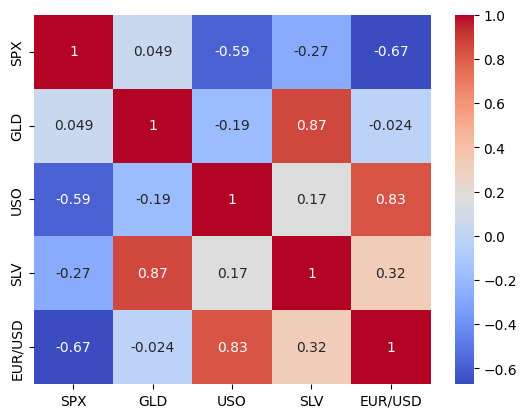

In [24]:
sns.heatmap(df.corr(numeric_only= True), annot = True, cmap = 'coolwarm')
plt.show()

Text(0, 0.5, 'Counts')

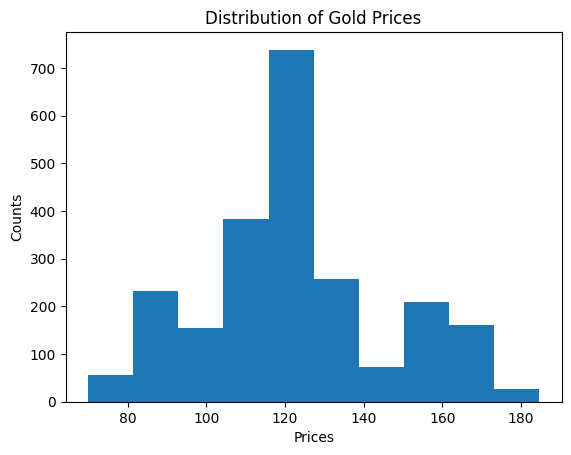

In [25]:
plt.hist(df.GLD)
plt.title('Distribution of Gold Prices')
plt.xlabel('Prices')
plt.ylabel('Counts')

In [26]:
X = df.drop(columns = ['Date', 'GLD'])
y = df.GLD

split_index = int(len(df)*0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1832, 4)
(458, 4)
(1832,)
(458,)


In [29]:
tscv = TimeSeriesSplit(n_splits=5)

In [30]:
models = {
    'LinearRegression':{
        'model' : LinearRegression(),
        'params': {}
    },
    'Ridge':{
        'model': Ridge(random_state= 2),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso':{
        'model': Lasso(random_state= 2),
        'params':{
            'alpha' : [0.1, 1.0, 10.0, 100.0]
        }
    },
    'RandomForestRegressor':{
        'model': RandomForestRegressor(random_state= 2),
        'params':{
            'max_depth': [10, 15, 20],
            'min_samples_split': [20,50],
            'n_estimators': [50, 100]
        }
    },
    'XGBRegressor':{
        'model': XGBRegressor(random_state = 2),
        'params': {
            'max_depth': [3, 5, 6],
            'learning_rate': [0.1, 0.2],
            'n_estimators':[50, 100]
        }
    }
}

In [31]:
results = {}

for name, config in models.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv = tscv,
        scoring = 'neg_mean_absolute_error',
        n_jobs = -1
    )

    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_

    train_pred = best_model.predict(X_train_scaled)
    test_pred = best_model.predict(X_test_scaled)

    results[name] = {
        'best_params' : grid_search.best_estimator_,
        'train_r2' : r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'train_mae' : mean_absolute_error(y_train, train_pred),
        'test_mae' : mean_absolute_error (y_test, test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred))
    }

In [32]:
summary_data = []

for name, result in results.items():
    summary_data.append({
    'Model': name,
    'Train MAE': result['train_mae'],
    'Test MAE': result['test_mae'],
    'Train RMSE' : result['train_rmse'],
    'Test RMSE' : result['test_rmse'],
    'Train R2' : result['train_r2'],
    'Test R2': result['test_r2']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print(summary_df.to_string(index = False))

                Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  Test R2
     LinearRegression     6.6085    4.6413      8.5986     5.8171    0.8898  -0.4440
                Ridge     6.6351    4.6247      8.5997     5.7951    0.8898  -0.4331
                Lasso     6.9636    3.8589      8.7648     4.9219    0.8855  -0.0338
RandomForestRegressor     1.3093    4.6054      2.1714     5.9355    0.9930  -0.5034
         XGBRegressor     1.9133    4.5371      2.7868     6.1068    0.9884  -0.5915


#### Conclusion
This analysis attempted to predict gold prices using four traditional market indicators: S&P 500 index, oil prices (USO), silver prices (SLV), and EUR/USD exchange rates. The results demonstrate that these variables have limited predictive power for gold price movements.

##### Why the Results Are Negative:
The negative R² values (-0.03 to -0.59) obtained with the corrected time-based train/test split indicate that all models performed worse than simply predicting the historical mean gold price. This occurs because:

##### Weak Feature Relationships: 
The correlation analysis revealed that most predictors have minimal correlation with gold prices (SPX: 0.049, EUR/USD: -0.024, USO: -0.19). Only silver showed strong correlation (0.87), but a single strongly correlated feature is insufficient for robust prediction.

##### Temporal Complexity: 
Gold prices are influenced by factors not captured in these four variables, including geopolitical events, inflation expectations, central bank policies, and market sentiment. The models cannot learn meaningful patterns from variables that lack predictive signal.

##### Market Efficiency: 
The negative results align with the efficient market hypothesis - if gold prices were easily predictable using readily available market data, arbitrage opportunities would quickly eliminate such patterns.